In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import imageio.v3 as iio
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glasmiccai2015-gland-segmentation/Warwick_QU_Dataset/testA_52_anno.bmp
/kaggle/input/glasmiccai2015-gland-segmentation/Warwick_QU_Dataset/train_1_anno.bmp
/kaggle/input/glasmiccai2015-gland-segmentation/Warwick_QU_Dataset/testA_60.bmp
/kaggle/input/glasmiccai2015-gland-segmentation/Warwick_QU_Dataset/train_72.bmp
/kaggle/input/glasmiccai2015-gland-segmentation/Warwick_QU_Dataset/train_35.bmp
/kaggle/input/glasmiccai2015-gland-segmentation/Warwick_QU_Dataset/testA_12_anno.bmp
/kaggle/input/glasmiccai2015-gland-segmentation/Warwick_QU_Dataset/train_61_anno.bmp
/kaggle/input/glasmiccai2015-gland-segmentation/Warwick_QU_Dataset/testB_19.bmp
/kaggle/input/glasmiccai2015-gland-segmentation/Warwick_QU_Dataset/testA_5_anno.bmp
/kaggle/input/glasmiccai2015-gland-segmentation/Warwick_QU_Dataset/train_12_anno.bmp
/kaggle/input/glasmiccai2015-gland-segmentation/Warwick_QU_Dataset/testA_49_anno.bmp
/kaggle/input/glasmiccai2015-gland-segmentation/Warwick_QU_Dataset/train_59_anno.bmp
/k

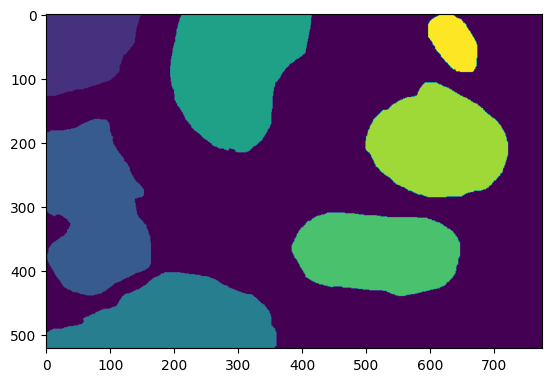

In [2]:
path = '/kaggle/input/glasmiccai2015-gland-segmentation/Warwick_QU_Dataset/train_1_anno.bmp'
image = iio.imread(path)
plt.imshow(image)
plt.show()

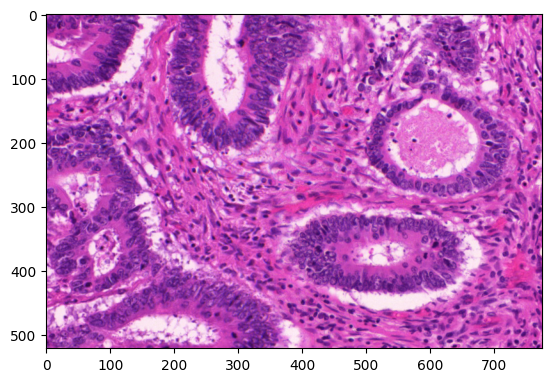

In [3]:
path = '/kaggle/input/glasmiccai2015-gland-segmentation/Warwick_QU_Dataset/train_1.bmp'
image = iio.imread(path)
plt.imshow(image)
plt.show()

In [4]:
path = '/kaggle/input/glasmiccai2015-gland-segmentation/Warwick_QU_Dataset/Grade.csv'
df = pd.read_csv(path)

In [5]:
df

,name,patient ID,grade (GlaS),grade (Sirinukunwattana et al. 2015)
0,testA_1,4,benign,adenomatous
1,testA_10,10,benign,healthy
2,testA_11,9,benign,healthy
3,testA_12,11,malignant,poorly differentiated
4,testA_13,7,malignant,moderately differentiated
...,...,...,...,...
160,train_82,2,malignant,moderately-to-poorly differentated
161,train_83,11,malignant,poorly differentiated
162,train_84,15,benign,healthy
163,train_85,10,benign,healthy


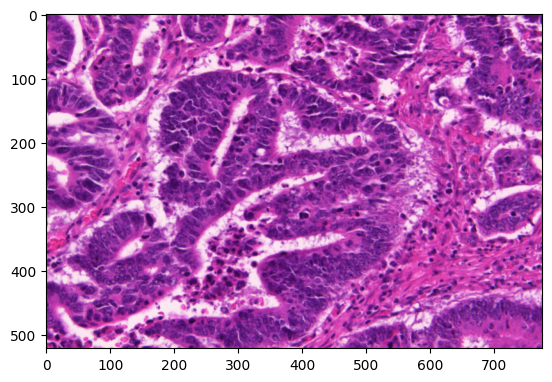

In [6]:
path = '/kaggle/input/glasmiccai2015-gland-segmentation/Warwick_QU_Dataset/train_82.bmp'
image = iio.imread(path)
plt.imshow(image)
plt.show()

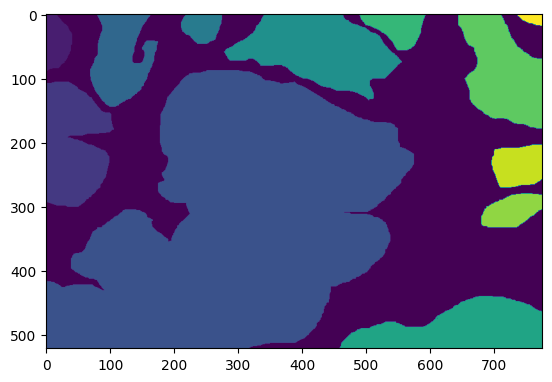

In [7]:
path = '/kaggle/input/glasmiccai2015-gland-segmentation/Warwick_QU_Dataset/train_82_anno.bmp'
image = iio.imread(path)
plt.imshow(image)
plt.show()

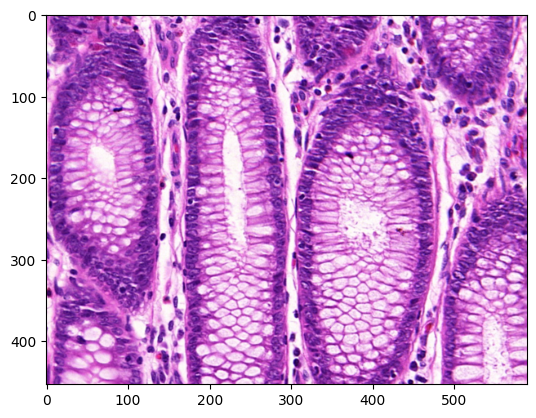

In [8]:
path = '/kaggle/input/glasmiccai2015-gland-segmentation/Warwick_QU_Dataset/train_84.bmp'
image = iio.imread(path)
plt.imshow(image)
plt.show()

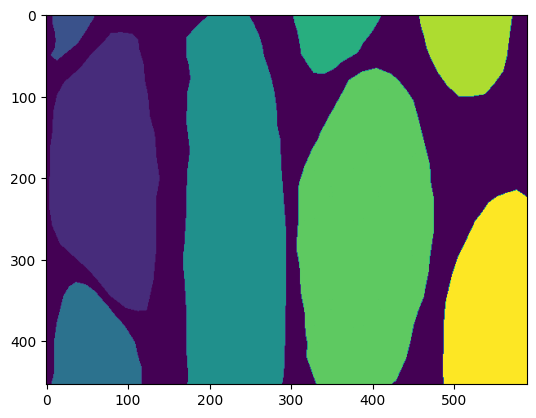

In [9]:
path = '/kaggle/input/glasmiccai2015-gland-segmentation/Warwick_QU_Dataset/train_84_anno.bmp'
image = iio.imread(path)
plt.imshow(image)
plt.show()

In [10]:
image.shape

(453, 589)